In [1]:
# Установка transformers
!pip install transformers

You should consider upgrading via the 'c:\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
#Установка catboost
!pip install catboost

You should consider upgrading via the 'c:\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
from itertools import groupby

In [4]:
#import необходимых модулей

import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostClassifier, Pool
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [5]:
#Считывание данных в DataFrame 
# Загружаются -
# данные трейна и теста после предобработки в кластеры
# ансамблевое решение catboost и xgboost 
# - несовпадающие решения и значения класса 1 помечены как 4 для выполнения прогноза завершающим 
# лучший промежуточный результат прогноза

train= pd.read_csv('train_cluster.csv', sep=';', index_col=None)
test= pd.read_csv('test_cluster.csv', sep=';', index_col=None)
prognoz_ansambl = pd.read_csv('Якутия ансамбль.csv', sep=',', index_col=None) 
prognoz_ansambl.columns=['id','Prognoz']
best_prom=pd.read_csv('Якутия замена лучший промежуточный результат.csv', sep=',', index_col=None)

In [6]:
# Замена Null
train=train.fillna(0)
test=test.fillna(0)
train.loc[(train['Образование']==0),'Образование']='Неизвестно'
train.loc[(train['Специальность']==0),'Специальность']='Неизвестно'
train.loc[(train['Виды документов']==0),'Виды документов']='Неизвестно'

test.loc[(test['Образование']==0),'Образование']='Неизвестно'
test.loc[(test['Специальность']==0),'Специальность']='Неизвестно'
test.loc[(test['Виды документов']==0),'Виды документов']='Неизвестно'

In [7]:
train['Задания кластер']=train['Задания кластер'].astype(int)
train['Звонки кластер']=train['Звонки кластер'].astype(int)
train['Опоздания кластер']=train['Опоздания кластер'].astype(int)
train['Рабочее время кластер']=train['Рабочее время кластер'].astype(int)
train['Компьютер кластер']=train['Компьютер кластер'].astype(int)
train['Активность кластер']=train['Активность кластер'].astype(int)
train['Обучений количество']=train['Обучений количество'].astype(int)

test['Задания кластер']=test['Задания кластер'].astype(int)
test['Звонки кластер']=test['Звонки кластер'].astype(int)
test['Опоздания кластер']=test['Опоздания кластер'].astype(int)
test['Рабочее время кластер']=test['Рабочее время кластер'].astype(int)
test['Компьютер кластер']=test['Компьютер кластер'].astype(int)
test['Активность кластер']=test['Активность кластер'].astype(int)
test['Обучений количество']=test['Обучений количество'].astype(int)

In [8]:
train

,id,Код подразделения,type,Задания кластер,Задания центр,Образование,Специальность,Табельный номер руководителя,Обучений количество,Звонки кластер,Звонки центр,Опоздания кластер,Опоздания центр,Будни Нет опоздания Время опозданий,Рабочее время кластер,Рабочее время центр,Компьютер кластер,Компьютер центр,Активность кластер,Активность центр,Виды документов
0,ОРГ1-02050,ОРГ1,2,7,0.457321,"Высшее образование - бакалавриат, Неполное выс...",Технологические машины и оборудование,не указано,2,1,0.164433,7,0.792786,0.042881,1,0.048544,1,0.370305,3,1.658982,Приказ
1,ОРГ1-02783,ОРГ1,2,1,0.663071,Высшее образование,Автоматизация технологических процессов и прои...,ОРГ1-01974,1,1,0.724931,7,0.808182,0.091828,0,0.000000,1,0.947611,3,1.411283,"Служебная записка, Файл"
2,ОРГ2-06173,ОРГ2,0,0,0.000000,Высшее образование,Управление качеством,ОРГ2-01170,1,0,0.000000,4,1.372025,0.533602,0,0.000000,0,0.000000,0,0.000000,Неизвестно
3,ОРГ2-05359,ОРГ2,2,0,0.000000,Среднее профессиональное образование,Технолог-сварщик,ОРГ2-09100,1,0,0.000000,7,1.053592,0.106454,0,0.000000,2,0.413357,1,0.851213,Неизвестно
4,ОРГ1-00803,ОРГ1,2,4,1.159688,Высшее образование,Журналистика,не указано,1,1,0.491434,3,0.648211,0.000000,0,0.000000,8,0.602660,2,1.328783,"Служебная записка, Файл"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,ОРГ1,2,2,0.653674,Неизвестно,Неизвестно,0,0,0,0.000000,0,0.000000,0.000000,0,0.000000,4,0.898312,7,1.905130,"Служебная записка, Файл"
546,ОРГ1-02383,ОРГ1,2,2,0.735304,Высшее образование,"Проектирование, сооружение и эксплуатация газо...",не указано,1,2,2.367431,2,1.302648,0.669084,6,0.371077,4,0.802069,1,1.524088,"Служебная записка, Файл"
547,ОРГ1-02862,ОРГ1,2,0,0.000000,Неизвестно,Неизвестно,0,0,0,0.000000,0,0.000000,0.000000,0,0.000000,6,1.205473,1,1.173048,Неизвестно
548,ОРГ1-00471,ОРГ1,2,1,1.129684,"Высшее образование, не указано","сооружение газонефтепроводов, газохранилищ и н...",не указано,2,2,1.742796,4,1.297791,0.147322,0,0.000000,3,1.033237,6,1.008928,"Распоряжение, Служебная записка"


In [9]:
test

,id,Код подразделения,type,Задания кластер,Задания центр,Образование,Специальность,Табельный номер руководителя,Обучений количество,Звонки кластер,Звонки центр,Опоздания кластер,Опоздания центр,Будни Нет опоздания Время опозданий,Рабочее время кластер,Рабочее время центр,Компьютер кластер,Компьютер центр,Активность кластер,Активность центр,Виды документов
0,ОРГ1-02649,ОРГ1,0,0,0.000000,Неизвестно,Неизвестно,0,0,1,0.492828,0,0.000000,0.000000,7,0.384645,1,0.708714,3,1.557715,Неизвестно
1,ОРГ2-05929,ОРГ2,0,0,0.000000,Высшее образование - бакалавриат,Инженерно-геодезическое обеспечение и техничес...,ОРГ2-00539,1,0,0.000000,7,0.833921,0.173267,0,0.000000,3,0.930472,7,1.379259,Неизвестно
2,ОРГ2-05859,ОРГ2,0,7,1.087509,Среднее общее образование,не указано,ОРГ2-04561,1,0,0.000000,1,1.185085,4.935355,0,0.000000,5,1.201870,8,1.116911,"Входящий, Служебная записка"
3,ОРГ1-00279,ОРГ1,0,1,0.358147,"Высшее образование, Повышение квалификации","Промышленное и гражданское строительство, не у...",ОРГ1-00483,2,4,2.093280,7,0.485092,0.344013,8,0.737975,1,1.201789,8,1.544001,"Служебная записка, Файл"
4,ОРГ2-01613,ОРГ2,0,10,1.106459,"Высшее образование - специалитет, магистратура",Промышленное и гражданское строительство,ОРГ2-02458,1,0,0.000000,7,1.175586,2.227617,0,0.000000,3,1.057278,3,1.001176,"Входящий, Распоряжение"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,ОРГ1,0,7,0.457198,Среднее профессиональное образование,Менеджмент,не указано,1,1,1.006048,8,1.207824,1.517479,0,0.000000,2,0.995992,1,0.792806,"Распоряжение, Служебная записка"
258,ОРГ2-01077,ОРГ2,0,7,1.605161,"Высшее образование - специалитет, магистратура",Астрономогеодезия,ОРГ2-09100,1,0,0.000000,4,1.634936,0.951791,0,0.000000,4,1.240152,3,2.436821,"Приказ, Служебная записка"
259,ОРГ1-00469,ОРГ1,0,1,0.555824,Высшее образование,Менеджмент организации,ОРГ1-01974,1,8,0.830843,7,0.768754,0.046140,7,0.337214,1,1.274786,3,1.014967,"Служебная записка, Файл"
260,ОРГ1-02060,ОРГ1,0,7,1.608024,Высшее образование,"Проектирование, сооружение и эксплуатация газо...",не указано,1,1,0.296230,3,0.792935,0.030736,0,0.000000,8,0.671345,2,1.223393,"Служебная записка, Файл"


In [10]:
train.columns

Index(['id', 'Код подразделения', 'type', 'Задания кластер', 'Задания центр',
       'Образование', 'Специальность', 'Табельный номер руководителя',
       'Обучений количество', 'Звонки кластер', 'Звонки центр',
       'Опоздания кластер', 'Опоздания центр',
       'Будни Нет опоздания Время опозданий', 'Рабочее время кластер',
       'Рабочее время центр', 'Компьютер кластер', 'Компьютер центр',
       'Активность кластер', 'Активность центр', 'Виды документов'],
      dtype='object')

In [11]:
# Создаем тест из непредсказанных единиц
test_new=prognoz_ansambl.loc[prognoz_ansambl['Prognoz']==4]
test_new=test_new.merge(test,how='left',on='id')
test_new

,id,Prognoz,Код подразделения,type,Задания кластер,Задания центр,Образование,Специальность,Табельный номер руководителя,Обучений количество,Звонки кластер,Звонки центр,Опоздания кластер,Опоздания центр,Будни Нет опоздания Время опозданий,Рабочее время кластер,Рабочее время центр,Компьютер кластер,Компьютер центр,Активность кластер,Активность центр,Виды документов
0,ОРГ2-05171,4,ОРГ2,0,1,0.748992,Среднее профессиональное образование,Программирование в компьютерных системах,ОРГ2-09100,1,0,0.000000,4,1.221584,0.071344,0,0.000000,4,1.437801,1,1.312508,"Внутренний документ для БП синхронизация 1С, С..."
1,ОРГ1-01851,4,ОРГ1,0,1,0.561547,Высшее образование,Стандартизация и сертификация,ОРГ1-00634,1,8,1.072132,8,1.657255,2.478485,1,0.943975,2,1.259708,3,1.805396,"Служебная записка, Файл"
2,ОРГ1-00571,4,ОРГ1,0,1,0.690474,Высшее образование,Теория и методика преподавания иностранных язы...,ОРГ1-00571,1,1,0.489213,3,1.217472,0.000000,0,0.000000,8,0.777402,2,1.076349,"Служебная записка, Файл"
3,ОРГ1-02494,4,ОРГ1,0,1,1.148133,"Высшее образование - бакалавриат, Высшее образ...",Химическая технология,ОРГ1-00772,2,1,0.371815,2,2.203803,3.303919,0,0.000000,2,1.288625,7,1.189715,"Распоряжение, Файл"
4,ОРГ1-01590,4,ОРГ1,0,1,0.589772,"Высшее образование, не указано","Оборудование нефтегазопереработки, не указано",не указано,2,8,1.269136,7,0.858599,1.875482,1,0.381888,1,0.353192,3,1.113022,"Служебная записка, Файл"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,ОРГ2-04214,4,ОРГ2,0,7,1.310112,Высшее образование,Юриспруденция,не указано,1,0,0.000000,7,0.536810,0.920921,0,0.000000,3,0.754833,3,2.359190,"Служебная записка, Файл"
110,ОРГ2-04036,4,ОРГ2,0,1,1.365439,Высшее образование - бакалавриат,Юриспруденция,не указано,1,0,0.000000,7,0.734777,0.372237,0,0.000000,1,0.592710,8,0.665549,"Служебная записка, Файл"
111,ОРГ2-01077,4,ОРГ2,0,7,1.605161,"Высшее образование - специалитет, магистратура",Астрономогеодезия,ОРГ2-09100,1,0,0.000000,4,1.634936,0.951791,0,0.000000,4,1.240152,3,2.436821,"Приказ, Служебная записка"
112,ОРГ1-00469,4,ОРГ1,0,1,0.555824,Высшее образование,Менеджмент организации,ОРГ1-01974,1,8,0.830843,7,0.768754,0.046140,7,0.337214,1,1.274786,3,1.014967,"Служебная записка, Файл"


In [12]:
columns_to_train=['Код подразделения',  'Задания кластер', 'Задания центр',
       'Образование', 'Специальность', 
       'Обучений количество', 'Звонки кластер', 'Звонки центр',
       'Опоздания кластер', 'Рабочее время кластер', 'Компьютер кластер',
       'Опоздания центр', 'Активность кластер', 'Рабочее время центр','Табельный номер руководителя',
       'Компьютер центр', 'Активность центр','Будни Нет опоздания Время опозданий','Виды документов'
]

In [13]:
# выбираем поля для нейросети СatBoost

X_train=train[columns_to_train]
y_train=train[['type']]

testnet=test_new[columns_to_train]

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Код подразделения                    550 non-null    object 
 1   Задания кластер                      550 non-null    int32  
 2   Задания центр                        550 non-null    float64
 3   Образование                          550 non-null    object 
 4   Специальность                        550 non-null    object 
 5   Обучений количество                  550 non-null    int32  
 6   Звонки кластер                       550 non-null    int32  
 7   Звонки центр                         550 non-null    float64
 8   Опоздания кластер                    550 non-null    int32  
 9   Рабочее время кластер                550 non-null    int32  
 10  Компьютер кластер                    550 non-null    int32  
 11  Опоздания центр                 

In [15]:
# Определяем веса для классов кластеров
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.8986928104575164, 1: 1.8581081081081081, 2: 0.46140939597315433, 3: 5.5}

In [16]:
#X_train,X_test,y_train,y_test = train_test_split(X_train, 
#                                                 y_train, 
#                                                 test_size=0.2, 
#                                                 random_state=29)
testnet_solution = Pool(testnet, cat_features = ['Код подразделения','Задания кластер', 
         'Звонки кластер', 'Опоздания кластер', 'Рабочее время кластер', 'Компьютер кластер','Обучений количество', 'Табельный номер руководителя',
          'Активность кластер'], text_features = ['Образование', 'Специальность','Виды документов'])

In [17]:
#Обучаем 
pool_train_solution = Pool(X_train, y_train, cat_features = ['Код подразделения','Задания кластер', 
         'Звонки кластер', 'Опоздания кластер', 'Рабочее время кластер', 'Компьютер кластер','Обучений количество', 'Табельный номер руководителя',
          'Активность кластер'], text_features = ['Образование', 'Специальность','Виды документов'])
#pool_test_solution = Pool(X_test,y_test, cat_features = ['Код подразделения','Табельный номер руководителя'], text_features = ['Образование', 'Специальность'])
testnet_solution = Pool(testnet, cat_features = ['Код подразделения','Задания кластер', 
         'Звонки кластер', 'Опоздания кластер', 'Рабочее время кластер', 'Компьютер кластер','Обучений количество', 'Табельный номер руководителя',
          'Активность кластер'], text_features = ['Образование', 'Специальность','Виды документов'])

model_test = CatBoostClassifier(iterations=150,  task_type='CPU',depth=14, verbose =True, random_seed=15, learning_rate=0.005,
                               leaf_estimation_method= 'Gradient',bootstrap_type= 'MVS',objective='MultiClass',eval_metric = 'Accuracy',loss_function='MultiClass', class_weights=class_weights)
model_test.fit(pool_train_solution,verbose=True)
#model_test.fit(pool_train_solution,eval_set=pool_test_solution,verbose=True,early_stopping_rounds=25 )



0:	learn: 0.8209369	total: 19.5s	remaining: 48m 29s
1:	learn: 0.8585216	total: 24.3s	remaining: 29m 58s
2:	learn: 0.8453393	total: 44.6s	remaining: 36m 23s
3:	learn: 0.9084185	total: 1m 3s	remaining: 38m 45s
4:	learn: 0.9300339	total: 1m 23s	remaining: 40m 17s
5:	learn: 0.9367892	total: 1m 43s	remaining: 41m 30s
6:	learn: 0.9234753	total: 1m 43s	remaining: 35m 21s
7:	learn: 0.9392394	total: 2m 3s	remaining: 36m 40s
8:	learn: 0.9468790	total: 2m 24s	remaining: 37m 38s
9:	learn: 0.9302306	total: 2m 25s	remaining: 33m 58s
10:	learn: 0.9227680	total: 2m 25s	remaining: 30m 42s
11:	learn: 0.9419332	total: 2m 47s	remaining: 32m 4s
12:	learn: 0.9395041	total: 3m 7s	remaining: 32m 56s
13:	learn: 0.9353533	total: 3m 7s	remaining: 30m 21s
14:	learn: 0.9452011	total: 3m 28s	remaining: 31m 15s
15:	learn: 0.9501469	total: 3m 47s	remaining: 31m 45s
16:	learn: 0.9451346	total: 3m 52s	remaining: 30m 19s
17:	learn: 0.9510297	total: 4m 12s	remaining: 30m 50s
18:	learn: 0.9501681	total: 4m 32s	remaining: 

In [18]:
# предварительный тест схождения на всем обучающем множестве
y_pred = model_test.predict(X_train)
train['Prognoz_fin']=y_pred
train['Prognoz_fin'].value_counts()

2    312
1    122
0     93
3     23
Name: Prognoz_fin, dtype: int64

In [19]:
print("Значение метрики recall на трейне : ", recall_score(y_train, y_pred, average='macro', zero_division=True))

Значение метрики recall на трейне :  0.694073242211813


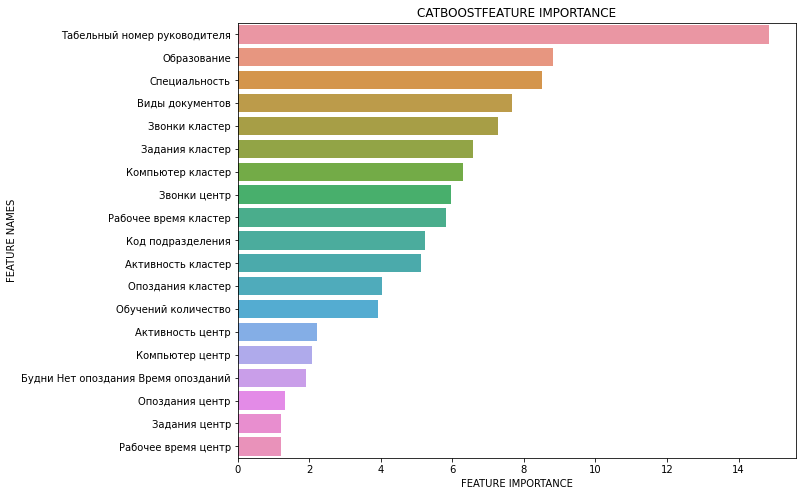

In [20]:
# Значимость признаков CatBoost в модели прогностики

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot the catboost result
plot_feature_importance(model_test.get_feature_importance(),X_train.columns,'CATBOOST')

In [21]:
#Получение ответов
y_pred_solution = model_test.predict(testnet_solution)

In [22]:
# Заводим результаты в тест
test_new['Prognoz_new']=y_pred_solution
test_new['Prognoz_new'].value_counts()

1    43
2    41
0    26
3     4
Name: Prognoz_new, dtype: int64

In [23]:
test_new=test_new[['id','Prognoz_new']]
test_new

,id,Prognoz_new
0,ОРГ2-05171,1
1,ОРГ1-01851,0
2,ОРГ1-00571,0
3,ОРГ1-02494,2
4,ОРГ1-01590,2
...,...,...
109,ОРГ2-04214,1
110,ОРГ2-04036,1
111,ОРГ2-01077,1
112,ОРГ1-00469,2


In [24]:
prognoz_ansambl

,id,Prognoz
0,ОРГ1-02649,3
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,2
258,ОРГ2-01077,4
259,ОРГ1-00469,4
260,ОРГ1-02060,2


In [25]:
prognoz_itog=prognoz_ansambl.merge(test_new,how='left',on='id')
prognoz_itog

,id,Prognoz,Prognoz_new
0,ОРГ1-02649,3,NaN
1,ОРГ2-05929,0,NaN
2,ОРГ2-05859,0,NaN
3,ОРГ1-00279,0,NaN
4,ОРГ2-01613,0,NaN
...,...,...,...
257,ОРГ1-02893,2,NaN
258,ОРГ2-01077,4,1.0
259,ОРГ1-00469,4,2.0
260,ОРГ1-02060,2,NaN


In [26]:
prognoz_itog.loc[~prognoz_itog['Prognoz_new'].isna(),'Prognoz']=prognoz_itog['Prognoz_new']
prognoz_itog['Prognoz'].value_counts()

2    157
0     49
1     43
3     13
Name: Prognoz, dtype: int64

In [27]:
prognoz_itog=prognoz_itog[['id','Prognoz']]
prognoz_itog['Prognoz']=prognoz_itog['Prognoz'].astype(int)


C:\Users\balan\AppData\Local\Temp\ipykernel_12920\4132247294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognoz_itog['Prognoz']=prognoz_itog['Prognoz'].astype(int)


In [28]:
prognoz_itog.columns=['id','type']
prognoz_itog

,id,type
0,ОРГ1-02649,3
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,2
258,ОРГ2-01077,1
259,ОРГ1-00469,2
260,ОРГ1-02060,2


In [29]:
prognoz_itog.to_csv('Якутия финал_603837.csv', sep=',', index=None)

In [30]:
# поскольку прогноз на кластеризации явно перекошен по классу 1 (с занижением класса 0),
# итоговый результат корректируется по лучшему промежуточному
best_prom.columns=['id','type_1']
prognoz_itog_balance=prognoz_itog.merge(best_prom,on='id',how='left')
prognoz_itog_balance.loc[(prognoz_itog_balance['type_1']==0),'type']=0
prognoz_itog_balance.loc[(prognoz_itog_balance['type_1']==2)&(prognoz_itog_balance['type']==1),'type']=2
prognoz_itog_balance['type_1']=prognoz_itog_balance['type']
prognoz_itog_balance['type']=best_prom['type_1']
prognoz_itog_balance.loc[(prognoz_itog_balance['type_1']==0)&(prognoz_itog_balance['type']==1),'type']=0
prognoz_itog_balance.loc[(prognoz_itog_balance['type_1']==0)&(prognoz_itog_balance['type']==2),'type']=0
prognoz_itog_balance.loc[prognoz_itog_balance['type_1']==3,'type']=3

prognoz_itog_balance['type'].value_counts()

2    133
0     77
1     40
3     12
Name: type, dtype: int64

In [31]:
prognoz_itog_balance=prognoz_itog_balance[['id','type']]
prognoz_itog_balance.to_csv('Якутия окончательный прогноз.csv', sep=',', index=None)